#### References
Dataset - https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate way of determining the polarity (positivity/negativity) of a review.

#### Loading the data
The dataset is available in two forms
1. .csv file
2. SQLite Database

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa

from sklearn.feature_extraction.text import CountVectorizer  ## BOW Model
from sklearn.feature_extraction.text import TfidfVectorizer  ## TFIDF Model

from sklearn.manifold import TSNE    ## To visualize high dimensional data

## Modules to perform Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords

import gensim    ## To build Word2Vec model

C:\Users\HARSHALL\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
conn = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", conn)

conn.close()

filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Note:** Time is stored is the unix timestamp

In [3]:
filtered_data.shape

(525814, 10)

In [ ]:
filtered_data

In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

## Pandas Series have a map function which apply function object to all the elements
filtered_data['Score'] = filtered_data['Score'].map(partition)

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## EDA
#### Data Cleaning - Removing the duplicates (Data Deduplication)
Many real world data contain duplicate entries which must be removed otherwise we may get biased results<br>
There are sayings in ML that **Garbage in - Garbage out**, and **Better Data beats Fancier Algorithms**

In [8]:
filtered_data['Time'].nunique()

3157

In [10]:
filtered_data['Time'].unique()

array([1303862400, 1346976000, 1219017600, ..., 1090627200, 1072915200,
       1087776000], dtype=int64)

In [11]:
filtered_data[filtered_data['Time'] == 1303862400]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
679,731,B002U56JXK,A1PIDGL665V5QP,Rod Jonse,2,2,positive,1303862400,Unparalleled taste,I purchased this 24 pack of Big Ass soda and o...
680,732,B002U56JXK,ASC04R0BT3TO4,"the BURNiNATOR ""raggle fraggle""",2,2,positive,1303862400,Amazing,"Well being the big red fan that I am, I bought..."
1520,1648,B001RVFDOO,A18GRF94T65X9Z,Reem Chavez,0,0,positive,1303862400,Best chips!,I wa hesitant about ordering this product simp...
2245,2440,B0089SPDUW,A163RZETDROJL5,"D. Johnson ""Dr. Duck""",0,0,positive,1303862400,Best K-cup out there.,So Far this is the only K-cup I've found thats...
5823,6302,B001D6F1PY,A2S4DN72TMWC2C,"Andy M. ""techno-geek""",0,0,positive,1303862400,Makes THE BEST risotto!,If you want to make authentic Italian risotto ...
8166,8935,B0007A0AP8,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,positive,1303862400,The price is right,We have a little Maltese that we spoil to no e...
14189,15489,B000255OIG,A3W35OAAB4XNX9,Maryann Aniela Royster,0,0,positive,1303862400,dogs love them,"all natural,dogs favorite treat. Don't give to..."
17152,18706,B00008JOL0,A1WSMYIW8APC5C,KN,0,0,positive,1303862400,My dog loves these!,My dog really loves these treats - and he's ve...
18110,19737,B0030VBRIU,A2P7TE7CVQAHH7,Dana Puckett,5,5,positive,1303862400,Don't give up and give it more then one try!,I gave this flavor to my 6 month old son but h...


In [17]:
filtered_data[(filtered_data['Time'] == 1303862400) & (filtered_data['ProfileName'] == 'R. Ellis "Bobby"')]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
8166,8935,B0007A0AP8,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,positive,1303862400,The price is right,We have a little Maltese that we spoil to no e...
113110,122699,B001MWRT2W,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",0,0,positive,1303862400,I think he likes them. But not as much as Gre...,We have a little Maltese that is given a <a hr...
146203,158601,B000MLG4K2,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",4,4,positive,1303862400,"He likes them, but I don't think he loves them...","To be fair, our dog is spoiled. He gets treat..."
162162,175817,B0014DUUFC,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,positive,1303862400,The price is right,We have a little Maltese that we spoil to no e...
242677,263188,B001BOXBHI,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",4,4,positive,1303862400,"He likes them, but I don't think he loves them...","To be fair, our dog is spoiled. He gets treat..."
325087,351843,B001MWRT0Y,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",0,0,positive,1303862400,I think he likes them. But not as much as Gre...,We have a little Maltese that is given a <a hr...
494170,534267,B0007A0AOY,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,positive,1303862400,The price is right,We have a little Maltese that we spoil to no e...
504729,545770,B001E5E1C8,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,positive,1303862400,The price is right,We have a little Maltese that we spoil to no e...


**Observations:**
1. Go to www.amazon.com/dp/_Product_ID   - dp means detailed page - found using Google
2. Check for ProductIDs - B0007A0AP8, B0007A0AOY and B001E5E1C8 - "UserId","ProfileName","Time","Text" are exactly the same
2. Product ID is also called ASIN - Amazon Standard Identification Number
3. These are variations of the same product and probably the user has bought only one of them but Amazon might allow the manufacturer "Zukes" in this case to share rviews between its product variants
4. Note: in the to product pages, "customer reviews" and "answered questions" are exactly same
5. Getting the same text in train and test will lead to biased results

In [22]:
#Sorting data according to ProductId in ascending order - To have consistent results
sorted_data = filtered_data.sort_values('ProductId')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})
final.shape

(364173, 10)

**Observe:** We are left with approx 69% of the original data after cleaning which means more than 30% was duplicate data

**Note:** HelpfulnessNumerator must always be less than or equal to HelpfulnessDenominator. Lets check if this always the case

In [23]:
final[final['HelpfulnessNumerator'] > final['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


There is something wrong in these two rows and must be removed

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [8]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

**Note:** Not a very balanced dataset

#### Data cleaning is an art, which requires a lot of intuition and common sense which comes by experience

#### Save the cleaned file in a new database

In [10]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
final.to_sql('Reviews', conn, if_exists='replace')
conn.close()

## Reading the updated sqlite - For future use you may directly read the below sqlite file

In [18]:
conn = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## Bag Of Words

In [12]:
## Initialize on object of the class CountVectorizer
bow_vect = CountVectorizer()
bow = bow_vect.fit_transform(final['Text'].values)

In [14]:
bow.get_shape()

(364171, 115281)

## TF-IDF

In [5]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(final['Text'].values)

In [6]:
tf_idf.shape

(364171, 115281)

## Text Preprocessing

#### We can see that many reviews contain HTML tags which are unwanted for our purpose

In [38]:
i = 0
for sen in final['Text'].values:
    if(len(re.findall('<.*?>', sen))):
        print(sen,"\n\n")
        i += 1
    if i == 5:
        break

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best. 


Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skatin

#### Stopwords are those words which do not provide much meaning to the sentences

In [2]:
stop = set(stopwords.words('english')) #set of stopwords

In [4]:
print(stop)

{'ll', 'all', 'to', 'shouldn', 'hadn', 'won', 'should', 'be', 'itself', 'a', 'had', 'from', 'in', 'where', 'why', 'between', 'himself', 'yours', 'i', 'that', 'but', 'of', 'having', 'you', 'him', 'don', 'than', 'above', 'this', 'on', 'herself', 'has', 'an', 'weren', 'can', 'own', 'and', 'he', 'they', 'been', 'these', 'most', 'me', 'through', 'am', 'their', 'doing', 'them', 'whom', 'yourself', 'with', 'doesn', 'after', 'up', 'isn', 'or', 'his', 'below', 'themselves', 'more', 'just', 'both', 'each', 'at', 'very', 'shan', 'not', 'over', 'how', 'if', 'myself', 'so', 'who', 'is', 'such', 'few', 'those', 'd', 'because', 'ourselves', 'about', 'before', 'here', 'her', 'wouldn', 'was', 't', 'the', 'ain', 'didn', 'couldn', 'are', 'during', 'wasn', 'no', 'm', 'as', 'by', 'same', 'now', 'hasn', 'o', 'have', 'hers', 'until', 'its', 're', 'were', 'your', 'it', 'our', 'then', 'mightn', 'will', 'needn', 'ma', 'does', 'against', 'once', 'under', 'aren', 'again', 'she', 'nor', 'which', 'did', 'off', 'out

**Personally** I feel that words like **won, nor, not, against** should not be treated as stopwords. So I would like to remove these words from the default stop words list. However these type of decisions depend on individuals

In [5]:
lst = ['won', 'nor', 'not', 'against']
for word in lst:
    stop.remove(word)
print(stop)

{'ll', 'all', 'to', 'shouldn', 'hadn', 'should', 'be', 'itself', 'a', 'had', 'from', 'in', 'where', 'why', 'between', 'himself', 'yours', 'i', 'that', 'but', 'of', 'having', 'you', 'him', 'don', 'than', 'above', 'this', 'on', 'herself', 'has', 'an', 'weren', 'can', 'own', 'and', 'he', 'they', 'been', 'these', 'most', 'me', 'through', 'am', 'their', 'doing', 'them', 'whom', 'yourself', 'with', 'doesn', 'after', 'up', 'isn', 'or', 'his', 'below', 'themselves', 'more', 'just', 'both', 'each', 'at', 'very', 'shan', 'over', 'how', 'if', 'myself', 'so', 'who', 'is', 'such', 'few', 'those', 'd', 'because', 'ourselves', 'about', 'before', 'here', 'her', 'wouldn', 'was', 't', 'the', 'ain', 'didn', 'couldn', 'are', 'during', 'wasn', 'no', 'm', 'as', 'by', 'same', 'now', 'hasn', 'o', 'have', 'hers', 'until', 'its', 're', 'were', 'your', 'it', 'our', 'then', 'mightn', 'will', 'needn', 'ma', 'does', 'once', 'under', 'aren', 'again', 'she', 'which', 'did', 'off', 'out', 'my', 've', 'down', 'theirs',

#### Stemming
In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form

In [3]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#### Example of stemming

In [11]:
print(sno.stem("operating"))
print(sno.stem("operated"))
print(sno.stem("operation"))
print(sno.stem("operate"))

oper
oper
oper
oper


#### Function to clean HTML tags in a given sentence

In [11]:
def cleanhtml(sentence):
    '''This function removes all the html tags in the given sentence'''
    cleanr = re.compile('<.*?>')    ## find the index of the html tags
    cleantext = re.sub(cleanr, ' ', sentence)  ## Substitute <space> in place of any html tag
    return cleantext

In [43]:
cleanhtml("hello<br /br>World")

'hello World'

#### Function to remove punctuations or special characters from a given sentence

In [12]:
def cleanpunc(sentence):
    '''This function cleans all the punctuation or special characters from a given sentence'''
    cleaned = re.sub(r'[?|@|!|^|%|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
cleanpunc("H?e^l@l/o #W(o!r%l.d,)")

'Hell o W orl d  '

#### Function to implement preprocessing steps

In [30]:
def preprocessing(series):
    '''The function takes a Pandas Series object containing text in all the cells
       And performs following Preprocessing steps on each cell:
       1. Clean text from html tags
       2. Clean text from punctuations and special characters
       3. Retain only non-numeric Latin characters with lenght > 2
       4. Remove stopwords from the sentence
       5. Apply stemming to all the words in the sentence
       
       Return values:
       1. final_string - List of cleaned sentences
       2. list_of_sent - List of lists which can be used as input to the W2V model'''
    
    i = 0
    str1=" "
    final_string = []    ## This list will contain cleaned sentences
    list_of_sent = []    ## This is a list of lists used as input to the W2V model at a later stage
    
    ## Creating below lists for future use
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here
    
    
    for sent in series.values:
        ## 
        filtered_sent = []
        sent = cleanhtml(sent)    ## Clean the HTML tags
        sent = cleanpunc(sent)    ## Clean the punctuations and special characters
        ## Sentences are cleaned and words are handled individually
        for cleaned_words in sent.split():
            ## Only consider non-numeric words with length at least 3
            if((cleaned_words.isalpha()) and (len(cleaned_words) > 2)):
                ## Only consider words which are not stopwords and convert them to lowet case
                if(cleaned_words.lower() not in stop):
                    ## Apply snowball stemmer and add them to the filtered_sent list
                    s = (sno.stem(cleaned_words.lower()))#.encode('utf-8')
                    filtered_sent.append(s)    ## This contains all the cleaned words for a sentence
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews
        ## Below list is a list of lists used as input to W2V model later
        list_of_sent.append(filtered_sent)
        ## Join back all the words belonging to the same sentence
        str1 = " ".join(filtered_sent)
        ## Finally add the cleaned sentence in the below list
        final_string.append(str1)
        #print(i)
        i += 1
    return final_string, list_of_sent

#### First 5 rows without preprocessing

In [15]:
for x in final['Text'].iloc[:5].values:
    print(x,"\n\n")

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college 


I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open. 


This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem. 


This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice".  The child g

#### First 5 rows after preprocessing

In [31]:
final_string, list_of_sent = preprocessing(final['Text'].iloc[:5])
for x in final_string:
    print(x,"\n\n")

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg 


grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open 


fun way children learn month year learn poem throughout school year like handmot invent poem 


great littl book read nice rhythm well good repetit littl one like line chicken soup rice child get month year wonder place like bombay nile eat well know get eat kid mauric sendak version ice skate treat rose head long time wont even know came surpris came littl witti book 


book poetri month year goe month cute littl poem along love book realli fun way learn month poem creativ author purpos write book give children fun way learn month children also learn thing poetri rhythm read book 




In [28]:
## This takes around 1 hour
final_string, list_of_sent = preprocessing(final['Text'])

In [24]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review

In [25]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


#### Save the updated DataFrame as an SQL Table for future use

In [27]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
final.to_sql('Reviews', conn, if_exists='replace', index = False)
conn.close()

#### Save the list_of_sent in a pickle file so that you can directly load the pickle file every time you use in future

In [49]:
with open('list_of_sent_for_input_to_w2v.pkl', 'wb') as pickle_file:
    pickle.dump(list_of_sent, pickle_file)

## BOW after cleaning

In [4]:
bow_vect = CountVectorizer()
bow = bow_vect.fit_transform(final['CleanedText'].values)
bow.shape

(364171, 71691)

#### Take a subset of 2000 points to visualize using TSNE

In [70]:
final['Score'].iloc[:2000].value_counts()

positive    1651
negative     349
Name: Score, dtype: int64

In [40]:
X = bow[:2000, :].toarray()
type(X)

numpy.ndarray

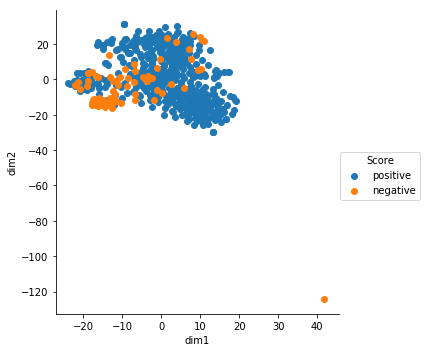

In [42]:
tsne = TSNE(n_components = 2, perplexity = 15).fit_transform(X)
df = pd.DataFrame(tsne, columns = ('dim1', 'dim2'))
df = pd.concat([df, final['Score'].iloc[:2000]], axis = 1)
sns.FacetGrid(df, hue = 'Score', size = 5).map(plt.scatter, 'dim1', 'dim2').add_legend()

#### Taking a subset of 5000 points

In [13]:
#X = bow[:5000, :].toarray()
#type(X)
#del(X)

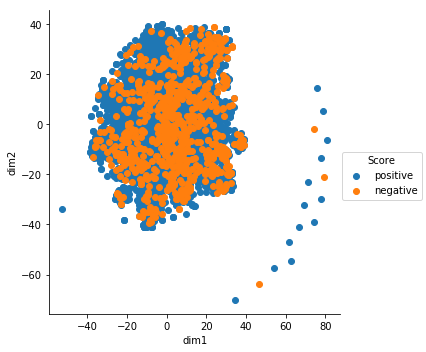

In [12]:
tsne = TSNE(n_components = 2, perplexity = 20).fit_transform(X)
df = pd.DataFrame(tsne, columns = ('dim1', 'dim2'))
df = pd.concat([df, final['Score'].iloc[:5000]], axis = 1)
sns.FacetGrid(df, hue = 'Score', size = 5).map(plt.scatter, 'dim1', 'dim2').add_legend()

## TFIDF after cleaning

In [17]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
tf_idf.shape

(364171, 71691)

#### Take a subset of 2000 points to visualize using TSNE

In [44]:
Y = tf_idf[:2000, :].toarray()
type(Y)

numpy.ndarray

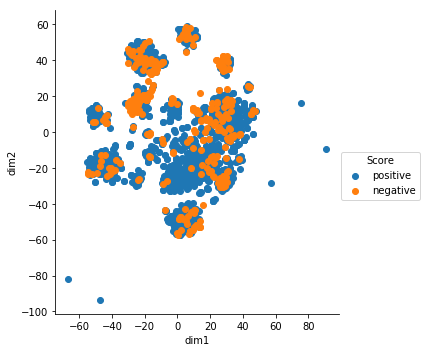

In [46]:
tsne = TSNE(n_components = 2, perplexity = 15).fit_transform(Y)
df1 = pd.DataFrame(tsne, columns = ('dim1', 'dim2'))
df1 = pd.concat([df, final['Score'].iloc[:2000]], axis = 1)
sns.FacetGrid(df, hue = 'Score', size = 5).map(plt.scatter, 'dim1', 'dim2').add_legend()

#### Taking a subset of 5000 points

In [18]:
Y = tf_idf[:5000, :].toarray()
type(Y)

numpy.ndarray

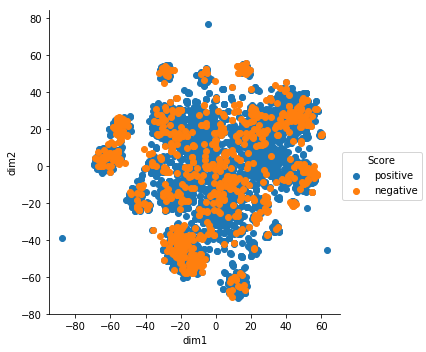

In [19]:
tsne = TSNE(n_components = 2, perplexity = 25).fit_transform(Y)
df = pd.DataFrame(tsne, columns = ('dim1', 'dim2'))
df = pd.concat([df, final['Score'].iloc[:5000]], axis = 1)
sns.FacetGrid(df, hue = 'Score', size = 5).map(plt.scatter, 'dim1', 'dim2').add_legend()

## W2V for CleanedText
#### Input to Word2Vec is a list of lists
* Outer list is a list of sentences
* Every inner list contains all the words belonging to one sentence

Tensorflow Tutorial - https://www.tensorflow.org/tutorials/word2vec

#### Read the pickle file - This was saved previously during the preprocessing phase, now loading it for giving input to W2V

In [6]:
with open('list_of_sent_for_input_to_w2v.pkl', 'rb') as pickle_file:
    list_of_sent = pickle.load(pickle_file)

**Try to understand what list_of_sent contains using below example**

In [50]:
final['CleanedText'].values[0]

'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

In [51]:
list_of_sent[0]

['witti',
 'littl',
 'book',
 'make',
 'son',
 'laugh',
 'loud',
 'recit',
 'car',
 'drive',
 'along',
 'alway',
 'sing',
 'refrain',
 'hes',
 'learn',
 'whale',
 'india',
 'droop',
 'love',
 'new',
 'word',
 'book',
 'introduc',
 'silli',
 'classic',
 'book',
 'bet',
 'son',
 'still',
 'abl',
 'recit',
 'memori',
 'colleg']

#### Training the Word2Vec model for words with min count 5

In [52]:
## size is the no of dimentsions
## min_count specifies the min no of times a word needs to occur to be included in the model
## workers is the number of cores on your PC
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

Check the number of unique words in the vocabulary of the model

In [53]:
words = list(w2v_model.wv.vocab)
print(len(words))

21885


**Check the most similar words to a given word**

In [56]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.8000462055206299),
 ('yummi', 0.79132080078125),
 ('tastey', 0.7200853228569031),
 ('satisfi', 0.6821063756942749),
 ('nice', 0.6736677885055542),
 ('good', 0.6704915761947632),
 ('hearti', 0.6580324769020081),
 ('nutriti', 0.6548944711685181),
 ('delish', 0.6481339931488037),
 ('crunchi', 0.6413717269897461)]

In [57]:
w2v_model.wv.most_similar('like')

[('weird', 0.733160138130188),
 ('okay', 0.7104317545890808),
 ('dislik', 0.6915770769119263),
 ('appeal', 0.6677860021591187),
 ('prefer', 0.6677730083465576),
 ('yucki', 0.6666367650032043),
 ('resembl', 0.6634767055511475),
 ('alright', 0.661238968372345),
 ('funki', 0.655515730381012),
 ('gross', 0.642878532409668)]

## Function to calculate Avg Word2Vec

In [20]:
def calc_avg_w2v(list_of_sent, w2v_model):
    '''This function takes in 2 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       
       Return Value:
       sent_vectors - This is a list of sentence/review vectors constructed by averaging the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        sent_vec = np.zeros(50)
        ## Initialize count of words to 0
        cnt_words = 0
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model.wv[word]
                ## Add the word vector to the sentence vector (This is the numerator)
                sent_vec += vec
                ## Sum all the word counts (This is the denominator)
                cnt_words += 1
            except:
                pass
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= cnt_words
        ## Add the sentence vector in the final list
        sent_vectors.append(sent_vec)
    ## return the list of all the sentence vectors
    return sent_vectors

In [ ]:
## Preparing the data to call the function

## Make sure "list_of_sent" is imported from the pickle file
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

#### Calling the above function

In [ ]:
## This takes around 15 minutes
sent_vectors = calc_avg_w2v(list_of_sent, w2v_model)

In [59]:
type(sent_vectors)

list

In [60]:
len(sent_vectors)

364171

In [61]:
sent_vectors[0]

array([-0.06582168,  0.26478676,  0.15748402,  0.02853077,  0.17577528,
        0.87079942,  0.10282963,  0.12515461, -0.28452162, -0.71627277,
        0.21696717,  0.11521968,  1.01649811, -0.21369366, -0.44944435,
       -0.15926586,  0.10972662, -0.14470267, -0.69901001,  0.01147728,
       -0.4536443 , -0.51498695, -0.37806134,  0.34904079, -0.42835609,
        0.36929333, -0.66197596,  0.26998774, -0.61783484,  0.33056465,
        0.25040469,  0.13446384,  0.42130212,  0.06687739, -0.5540252 ,
       -0.29407973,  0.60070674,  0.00122811,  0.14254314, -0.0322142 ,
        0.05099536,  0.86751848,  0.44559863,  0.05397169,  0.16505646,
        0.16378838,  0.50541587, -0.72783106, -0.485759  , -0.6230645 ])

In [62]:
with open('sent_vec_avg_w2v.pkl', 'wb') as pickle_file:
    pickle.dump(sent_vectors, pickle_file)

#### Read the averaged sentence vectors directly from here

In [12]:
with open('sent_vec_avg_w2v.pkl', 'rb') as pickle_file:
    sent_vectors = pickle.load( pickle_file)

In [14]:
sent_vec_array = np.array(sent_vectors)

In [64]:
type(sent_vec_array)

numpy.ndarray

In [15]:
sent_vec_array.shape

(364171, 50)

In [16]:
## Remove all the rows from the array which contain NaN values
sent_vec_array = sent_vec_array[~np.isnan(sent_vec_array).any(axis = 1)]
sent_vec_array.shape

(364167, 50)

#### TSNE: No of Points 2000, Perplexity = 30

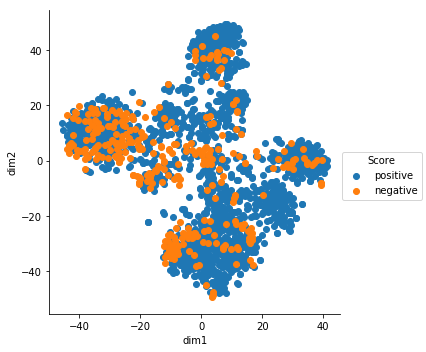

In [67]:
model = TSNE(n_components=2, perplexity = 30)
tsne = model.fit_transform(sent_vec_array[:2000, :])
d1 = pd.DataFrame(tsne, columns = ('dim1', 'dim2'))
d1 = pd.concat([d1, final['Score'].iloc[:2000]], axis = 1)
sns.FacetGrid(d1, hue = 'Score', size = 5).map(plt.scatter, 'dim1', 'dim2').add_legend()

#### TSNE: No of Points 2000, Perplexity = 15

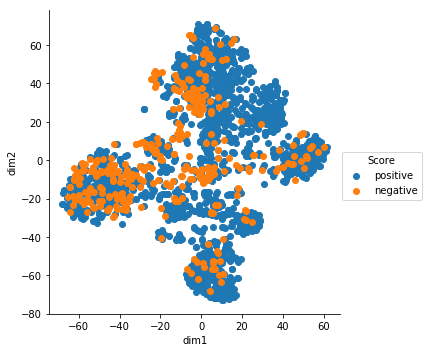

In [68]:
model = TSNE(n_components=2, perplexity = 15)
tsne = model.fit_transform(sent_vec_array[:2000, :])
d1 = pd.DataFrame(tsne, columns = ('dim1', 'dim2'))
d1 = pd.concat([d1, final['Score'].iloc[:2000]], axis = 1)
sns.FacetGrid(d1, hue = 'Score', size = 5).map(plt.scatter, 'dim1', 'dim2').add_legend()

#### TSNE - No of points 10000, Perplexity 25

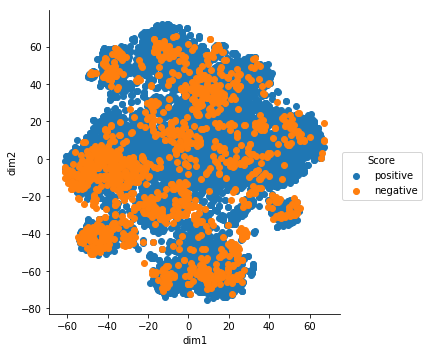

In [19]:
model = TSNE(n_components=2, perplexity = 25)
tsne = model.fit_transform(sent_vec_array[:10000, :])
d1 = pd.DataFrame(tsne, columns = ('dim1', 'dim2'))
d1 = pd.concat([d1, final['Score'].iloc[:10000]], axis = 1)
sns.FacetGrid(d1, hue = 'Score', size = 5).map(plt.scatter, 'dim1', 'dim2').add_legend()

## Function to calculate TFIDF weighted average Word2Vec

In [ ]:
def calc_tfidf_avg_w2v(list_of_sent, w2v_model, tf_idf, tfidf_feat):
    '''This function takes in 4 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       3. tf_idf - This is the TF-IDF model built using the same reviews/sentences - it is the TF-IDF sparse matrix
       4. tfidf_feat - This is the feature vector constructed from the TF-IDF model
       
       Return Value:
       tfidf_sent_vectors - This is a list of sentence/review vectors constructed by using tfidf weighted average on the word vectors
    '''
    
    ## Initialize an empty list
    tfidf_sent_vectors = []
    row = 0
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        sent_vec = np.zeros(50)
        ## Initialize weighted sum to 0
        weighted_sum = 0
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model.wv[word]
                ## Calculate tfidf value of the word in that review using tfidf model
                tfidf = tf_idf[row, tfidf_feat.index(word)]
                ## Add the product of tfidf*word_vec to the sentence vector (This is the numerator)
                sent_vec += vec*tfidf
                ## Sum all the tfidf values (This is the denominator)
                weighted_sum += tfidf
            except:
                pass
        #print(row, weighted_sum)
        
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= weighted_sum
        ## Add the sentence vector in the final list
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    ## return the list of all the sentence vectors
    return tfidf_sent_vectors

In [10]:
## Preparing the data to call the function

## Make sure "list_of_sent" is imported from the pickle file
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

To call **calc_tfidf_avg_w2v** to calculate tfidf weighted average sentence vectors, uncomment below cell and execute

#### Note: This will take 1hr for 4k points, which means around 100 hours/ 4 days for 364k points

In [ ]:
#tfidf_sent_vectors = calc_tfidf_avg_w2v(list_of_sent, w2v_model, tf_idf, tfidf_feat)